# GreenSurge event reconstruction example tropical cyclone VAMEI 2001

## Read simulation dataset

In [1]:
import xarray as xr

ds_GFD_info = xr.open_dataset(
    "outputs/GreenSurge_Singapur_info_updated.nc",
    decode_times=False,
)
ds_GFD_info

<xarray.Dataset> Size: 11MB
Dimensions:                            (element_computation_index: 421998,
                                        triangle_forcing_nodes: 3,
                                        node_forcing_index: 137,
                                        element_forcing_index: 207,
                                        wind_direction_index: 24,
                                        time_forcing_index: 4,
                                        node_cumputation_index: 219732)
Coordinates:
  * wind_direction_index               (wind_direction_index) int32 96B 0 ... 23
  * time_forcing_index                 (time_forcing_index) float64 32B 0.0 ....
    node_computation_longitude         (node_cumputation_index) float64 2MB ...
    node_computation_latitude          (node_cumputation_index) float64 2MB ...
    triangle_nodes                     (triangle_forcing_nodes) int32 12B ...
  * node_forcing_index                 (node_forcing_index) int32 548B 0 ... 136
  * element_forcing_index              (element_forcing_index) int32 828B 0 ....
  * node_cumputation_index             (node_cumputation_index) int32 879kB 0...
  * element_computation_index          (element_computation_index) int32 2MB ...
Dimensions without coordinates: triangle_forcing_nodes
Data variables: (12/14)
    triangle_computation_connectivity  (element_computation_index, triangle_forcing_nodes) int32 5MB ...
    node_forcing_longitude             (node_forcing_index) float64 1kB ...
    node_forcing_latitude              (node_forcing_index) float64 1kB ...
    triangle_forcing_connectivity      (element_forcing_index, triangle_forcing_nodes) int32 2kB ...
    wind_directions                    (wind_direction_index) int32 96B ...
    total_elements                     int32 4B ...
    ...                                 ...
    wind_speed                         int32 4B ...
    location_name                      object 8B ...
    eddy_viscosity                     int32 4B ...
    chezy_coefficient                  int32 4B ...
    reference_date                     object 8B ...
    forcing_time_step                  int32 4B ...
Attributes:
    title:        Hybrid Simulation Input Dataset
    description:  Structured dataset containing simulation parameters for hyb...
    created:      2025-06-12 19:32:55
    institution:  GeoOcean
    model:        GreenSurge

In [2]:
figsize = (6, 4)
instant = [15, 20, 30]

## Read the data from the international-best-track-archive-for-climate-stewardship-ibtracs (v04r01 NOAA)

In [ ]:
import numpy as np
from bluemath_tk.tcs.tracks import (
    historic_track_interpolation,
    historic_track_preprocessing,
)

p_ibtracs = "/lustre/geocean/DATA/GEOOCEAN/IBTrACS.ALL.v04r00.nc"

ibtracs = xr.open_dataset(p_ibtracs)

name = b"VAMEI"
TCname = "VAMEI2001"
year = 2001
centerID = "USA"

storm = ibtracs.isel(
    storm=np.where(
        (ibtracs.name == name)  # TODO: necesita \ ?
        & (ibtracs.time[:, 0].dt.year.values == year)
    )[0]
).isel(storm=0)

df_TC_hist = historic_track_preprocessing(xds=storm, center=centerID)

# computational time step mandatory [60 min] for GS methodology:
dt_comp = ds_GFD_info.time_step_hours.values * 60

# generate interpolated storm track and mandatory data to apply vortex model
storm_track, time_input = historic_track_interpolation(df=df_TC_hist, dt_comp=dt_comp)

## Select storm track for the period of interest

In [ ]:
# preprocess selected historic TC: obtain strom variables
# Storm fraction selection based on temporal coverture (period when the cyclone passes close to Tonga)

# VAMEI2001
tini = np.datetime64("2001-12-26T00:00")
tend = np.datetime64("2001-12-29T23:00")

storm_track_sel = storm_track[(storm_track.index >= tini) & (storm_track.index <= tend)]

## Gerenate a regular grid for the vortex model and apply the vortex model to the storm track

In [ ]:
from bluemath_tk.additive.greensurge import get_regular_grid
from bluemath_tk.tcs.vortex import vortex_model_grid

lon_grid, lat_grid = get_regular_grid(
    node_computation_longitude=ds_GFD_info.node_computation_longitude.values,
    node_computation_latitude=ds_GFD_info.node_computation_latitude.values,
    node_computation_elements=ds_GFD_info.triangle_computation_connectivity.values,
    factor=10,
    margin_deg=0.1,
)

xds_vortex_GS = vortex_model_grid(
    storm_track=storm_track_sel,
    cg_lon=lon_grid,
    cg_lat=lat_grid,
    coords_mode="SPHERICAL",
)

xds_vortex_GS.to_netcdf(
    f"outputs/GreenSurge_vortex_{TCname}.nc",
)

## Generation of sample points for estimating representative forcing cell means

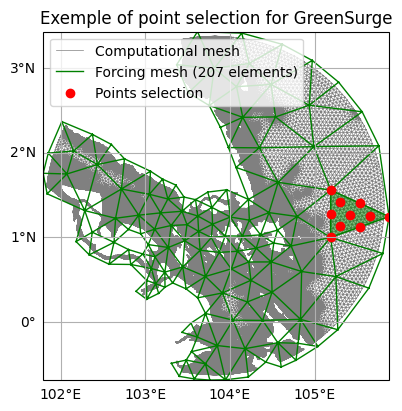

In [ ]:
from bluemath_tk.additive.greensurge import (
    generate_structured_points,
    plot_triangle_points,
)

lon_all, lat_all = generate_structured_points(
    triangle_connectivity=ds_GFD_info.triangle_forcing_connectivity.values,
    node_lon=ds_GFD_info.node_forcing_longitude.values,
    node_lat=ds_GFD_info.node_forcing_latitude.values,
)

plot_triangle_points(
    lon_all=lon_all, lat_all=lat_all, i=67, ds_GFD_info=ds_GFD_info, figsize=figsize
)

## Means realisation of the vortex model on the forcing grid

<div style="border: 1px solid #cce5ff; background-color: #e9f7fe; padding: 15px; border-radius: 6px; font-family: sans-serif;">
  <strong>🔹 Vortex Wind Fields</strong><br><br>

  The second stage for any TC event study includes: 
  <ul>
    <li>Partition of original TC-induced wind fields (regardless of their origin: from parameterizations using Holland vortex model or from forecasting systems) taking into account spatial (i.e. cells) and temporal (i.e. length of sustained winds) resolutions defined in stage 1. </li>
    <li>Search for analogues of the above wind forcing partition for each cell and time step in the corresponding forcings of the GFD pre-computed in stage 1. At this point, it is worth mentioning that, since a unit wind is used, the search for analogues is based on wind directions only. </li>
    <li>Re-scaling of the corresponding wind setup according to the realistic wind magnitude taking into account the quadratic expression of the wind shear stress used at the free surface boundary condition for the momentum equations. </li>
    <li>Summation of the re-scaled wind setup corresponding to the Green’s Fuctions selected by directional analogy for each time step </li>
  </ul>
</div>

In [ ]:
from bluemath_tk.additive.greensurge import interp_vortex_to_triangles

xds_vortex_interp = interp_vortex_to_triangles(
    xds_vortex_GS=xds_vortex_GS, lon_all=lon_all, lat_all=lat_all
)

## Exemples of instant of wind partitioning

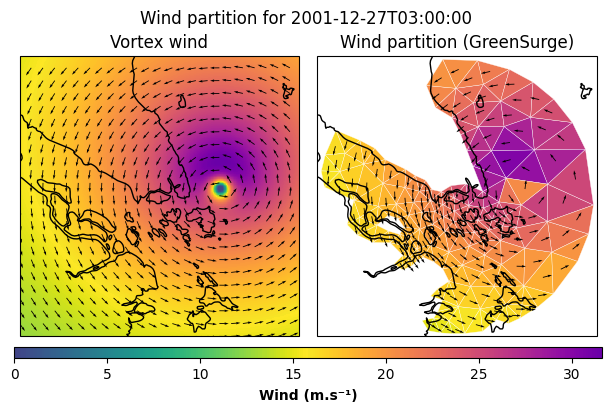

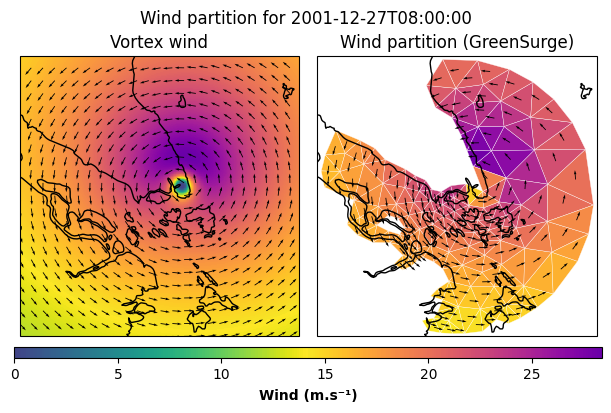

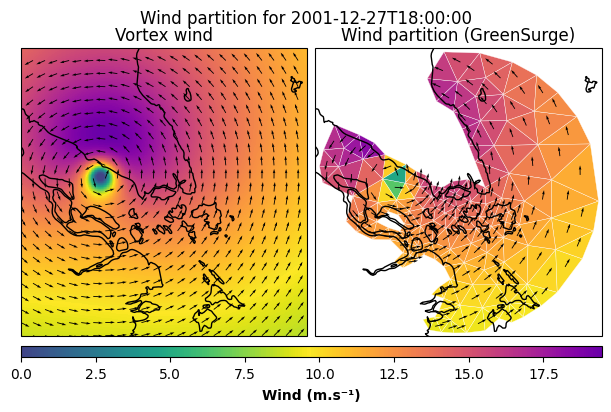

In [ ]:
from bluemath_tk.additive.greensurge import plot_GS_input_wind_partition

for i in instant:
    plot_GS_input_wind_partition(
        xds_vortex_GS=xds_vortex_GS,
        xds_vortex_interp=xds_vortex_interp,
        ds_GFD_info=ds_GFD_info,
        i_time=i,
        figsize=figsize,
    )

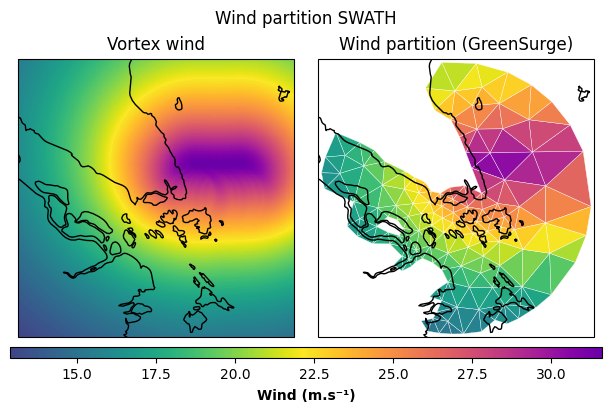

In [ ]:
plot_GS_input_wind_partition(
    xds_vortex_GS=xds_vortex_GS,
    xds_vortex_interp=xds_vortex_interp,
    ds_GFD_info=ds_GFD_info,
    SWATH=True,
    figsize=figsize,
)

## Loading the reconstruction library for this specific event

In [ ]:
from bluemath_tk.additive.greensurge import load_GS_database

p_GFD_libdir = "outputs/GreenSurge_Postprocess"

GFD = load_GS_database(
    xds_vortex_interp=xds_vortex_interp,
    ds_GFD_info=ds_GFD_info,
    p_GFD_libdir=p_GFD_libdir,
)

## Run: Searching for analogues, re-scaling and applying wind-drag coefficient

In [ ]:
from bluemath_tk.additive.greensurge import (
    GS_windsetup_reconstruction_with_postprocess_parallel,
)

xds_GS_wind = GS_windsetup_reconstruction_with_postprocess_parallel(
    greensurge_dataset=GFD,
    ds_gfd_metadata=ds_GFD_info,
    wind_direction_input=xds_vortex_interp,
    velocity_thresholds=np.array([0, 100, 100]),
    drag_coefficients=np.array([0.00063, 0.00723, 0.00723]),
)

xds_GS_wind.to_netcdf(f"outputs/GreenSurge_wind_setup_{TCname}.nc")

100%|██████████| 260/260 [02:46<00:00,  1.56it/s]
